# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor

In [2]:
random_seed = 3746

## Data

In [3]:
DATA_PATH = '../data/'

X_train = pd.read_pickle(DATA_PATH + 'X_train.pkl')
y_train = pd.read_pickle(DATA_PATH + 'y_train.pkl')
X_test = pd.read_pickle(DATA_PATH + 'X_test.pkl')
y_test = pd.read_pickle(DATA_PATH + 'y_test.pkl')

X_train.drop('id', axis=1, inplace=True)
X_test.drop('id', axis=1, inplace=True)


# Modeling

## Linear Regression

In [4]:
linreg = LinearRegression()
mse = -cross_validate(linreg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')['test_score'].mean()

rmse = np.sqrt(mse)
print(f'CV Score RMSE: {rmse}')

CV Score RMSE: 39.024050163400105


In [5]:
X_train

,Compartments,Weight Capacity (kg),Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Material_Leather,Material_Nylon,Material_Polyester,Style_Messenger,Style_Tote,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red
48338,9.0,5.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0
270688,4.0,14.898771,0,1,0,0,0,1,0,1,0,0,1,0,0,0
235982,5.0,23.010190,0,0,0,1,1,0,0,0,1,0,0,1,0,0
254122,9.0,14.165887,0,0,1,0,0,0,1,0,1,0,0,1,0,0
50273,8.0,24.913873,1,0,0,0,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230550,5.0,5.000000,1,0,0,0,0,0,1,1,0,0,0,0,0,1
239588,8.0,16.918774,0,0,1,0,0,0,0,0,1,0,0,0,1,0
20576,10.0,28.372044,0,1,0,0,0,0,0,0,0,0,0,0,1,0
195610,5.0,14.445700,0,0,0,1,0,1,0,0,0,0,1,0,0,0


In [6]:
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
print(f'Test set RMSE: {rmse}')

Test set RMSE: 39.01352159061797


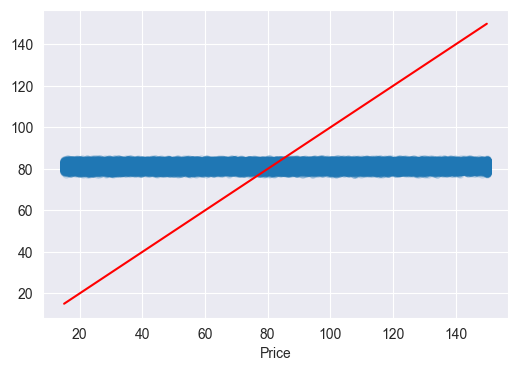

In [7]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.2, linewidth=0)
sns.lineplot(
    x=[y_test.min(), y_test.max()], 
    y=[y_test.min(), y_test.max()],
    color='red'
)
plt.show()

## LGBM Regressor

In [8]:
lgbm = LGBMRegressor(random_state=random_seed, verbose=-1)

mse = -cross_validate(lgbm, X_train, y_train, cv=5, scoring='neg_mean_squared_error')['test_score'].mean()

rmse = np.sqrt(mse)
print(f'CV Score RMSE: {rmse}')

CV Score RMSE: 39.031575080212015


In [9]:
lgbm.fit(X_train, y_train)

y_pred = lgbm.predict(X_test)

rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
print(f'Test set RMSE: {rmse}')

Test set RMSE: 39.01332238567065


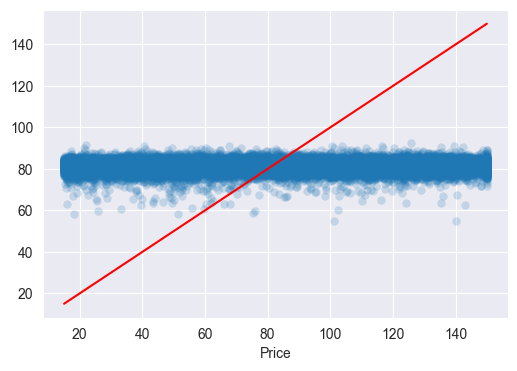

In [10]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.2, linewidth=0)
sns.lineplot(
    x=[y_test.min(), y_test.max()], 
    y=[y_test.min(), y_test.max()],
    color='red'
)
plt.show()

# Interpretation

## Feature Importances

In [11]:
feature_names = X_train.columns
importances = lgbm.feature_importances_

importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

In [12]:
def group_importances(df, original_variable):
    df[f'sub_{original_variable}'] = df['Feature'].apply(lambda x: 1 if original_variable in x else 0)

    style_row = pd.DataFrame({
        'Feature': [original_variable],
        'Importance': [df[df[f'sub_{original_variable}'] == 1]['Importance'].sum()],
        f'sub_{original_variable}': [0]
    })
    
    df = pd.concat([df, style_row], axis=0)
    df.reset_index(inplace=True, drop=True)
    
    to_drop_rows = df[df[f'sub_{original_variable}'] == 1].index
    df.drop(to_drop_rows, axis=0, inplace=True)
    df.drop(columns=f'sub_{original_variable}', inplace=True)
    
    df.sort_values(by='Importance', ascending=False, inplace=True)
    df.reset_index(inplace=True, drop=True)
    
    return df

In [ ]:
importances_df = group_importances(importances_df, 'Style')
importances_df = group_importances(importances_df, 'Color')
importances_df = group_importances(importances_df, 'Material')
importances_df = group_importances(importances_df, 'Brand')

/var/folders/yl/0x3dd7c54t1_c1v97db4kly40000gn/T/ipykernel_98072/3629139604.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances_df, palette='viridis')


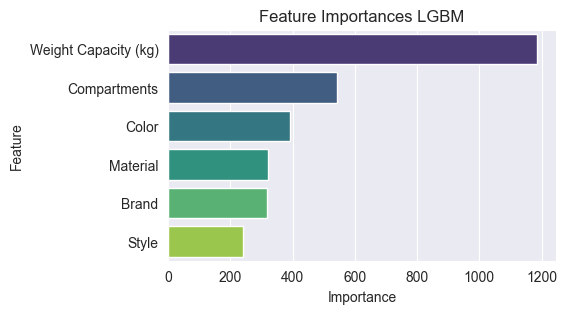

In [14]:
plt.figure(figsize=(5, 3))
sns.barplot(x='Importance', y='Feature', data=importances_df, palette='viridis')
plt.title('Feature Importances LGBM')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [15]:
importances = abs(linreg.coef_)

importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

In [16]:
importances_df = group_importances(importances_df, 'Style')
importances_df = group_importances(importances_df, 'Color')
importances_df = group_importances(importances_df, 'Material')
importances_df = group_importances(importances_df, 'Brand')

/var/folders/yl/0x3dd7c54t1_c1v97db4kly40000gn/T/ipykernel_98072/3629139604.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances_df, palette='viridis')


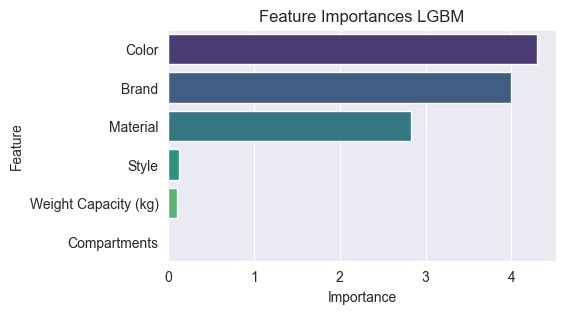

In [18]:
plt.figure(figsize=(5, 3))
sns.barplot(x='Importance', y='Feature', data=importances_df, palette='viridis')
plt.title('Feature Importances LGBM')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()